# A Differentiable Approximation for Entropies 

### 1. Entropy and Information Content in Neural Networks

Neural networks are just functions. Admittedly, highly parameterized functions, but yes - just functions: $x=f(y)$. Here, $y$ is some input - like e.g. an image - and $x$ is the output. Note that in contrast to what you usually see, we have swapped $x$ and $y$. Here's why: Consider the MNIST experiment: The neural network's job is actually to compute some kind of inverse of the *"writing down digit $x$ yielding image $y$"*-function. $x$ is what the MNIST instructor told the participants to write down. In statistical terms, this is the prior - denoted $x \sim \mathcal{X}$ (sample $x$ drawn from distribution $\mathcal{X}$). The partipants executed the (first human step of the) function producing pixels. In statistical terms they created the posterior pixel distribution $\mathcal{Y}$, arguably highly dependent on the prior.

Once the network is sufficiently trained (the function $f(y)$ is optimized), we dare to interpret the output as an estimation for the probability of that image to represent a particular digit, given the pixel intensities of that image. We say it's probably digit $x$ - not definitely. Even humans would agree that the following digit may be interpreted in different ways. You may in fact give it a 10% probability to be a three. To compute the accuracy of $f(y)$, we interpret the highest of all probabilities as the *prediction*, like "That image in fact *is* a digit 5".

![3_or_5](./5.png)

Training a neural network means exposing the network to a sufficiently large sample (the training set) from a probability distribution of pixel sets (images) and guide it (via Gradient Descent) to reproduce (infer) the digit that was meant by the hand-writing (the prior). In information theory, we call *"writing the digit down and making a photo of it"* a noisy encoding. The information about the original intent is still encoded in the image, but sometimes there's room for misinterpretations. Now, as the pixel distribution is passed through the neural network, at each layer we create a new a new distribution - this time of activations - from the original input. It would be interesting to understand how the information content changes from layer to layer. And that's where entropy enters the game. 

Aurelion Geron recorded an amazingly easy-to-grasp youtube clip called [Entropy, Cross-Entropy, & KL-Divergence](https://www.youtube.com/watch?v=ErfnhcEV1O8). If you're not already familiar with the concepts of entropy, I highly recommend it. Aurelion's warm-hearted french accent makes information theory even sound somewhat sexy. Of course, there is a plethora of more serious books out there. My personal favourite is Bavaud, Chappelier, Kohlas' comprehensive introductory text - a whopping 300 pages of math available as pdf:  [An Introduction to Information Theory and Applications](http://www.fon.hum.uva.nl/rob/Courses/InformationInSpeech/CDROM/Literature/LOTwinterschool2006/diuf.unifr.ch/tcs/courses/it04-05/script/information-theory.pdf)

Here's a summary of things you should know and understand to some degree:

##### Entropy 

$$ H(X) := -\sum_{x \in \mathcal{X}} p(x) \log p(x)$$

##### Conditional entropy 

$$ H(Y \big| X) := -\sum_{x \in \mathcal{X}} p(x) H(Y\big|X=x) = -\sum_{x \in \mathcal{X}} p(x) \sum_{y\in \mathcal{Y}} p(y|x) \cdot \log p(y|x) = -\sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log(\frac{p(x,y)}{p(x)})$$

##### Joint Entropy 

$$ H(Y, X) := -\sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log p(x,y)$$

##### Mutual information

$$ I(X;Y) := \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y)log(\frac{p(x,y)}{p(x)p(y)}) $$

##### Some useful properties 
$$ H(X,Y) \leq H(X)+H(Y)$$

$$ H(Y|X) = 0 \iff  \text{Y is completely determined by X} $$ 

$$ H(Y|X) = H(Y) \iff \text{X and Y are independent}$$

$$ H(Y|X) = H(Y,X) - H(X) $$

$$ I(X;Y) = H(X) + H(Y) - H(X,Y) $$

$$ I(X;Y) = H(Y) - H(Y|X) $$

Let's start with entropy. The entropy of a distribution is the average amount of information that we get when a particular sample is revealed to us. The weather in the Sahara has a low entropy, because if you tell me it's sunny there, I could have guessed that, anyway. Quite the opposite in e.g. Switzerland. Weather forecasts are always very appreciated, because the weather is changing so much. Same with digits: If you tell me that the center pixel of an image depicting the digit *zero* is white, that's not surprising at all. But if I didn't know what digit is displayed, that information would be very valuable, because it may be a good hint that the digit is a zero. The conditional entropy of the center pixel distribution, given $x=0$ is low. The overall entropy of the center pixel is higher. The difference between the entropy of a distribution and the conditional entropy given its prior is the *information gain* $I(X;Y) = H(Y) - H(Y|X)$.

### 2. Example: MNIST's Center Pixel Statistics
Why not leave theory for now and prove what I said about that center pixel: Let's calculate its entropy on a large training batch. And then compare that to the conditional entropy, i.e. the entropy of the subset of digits *zero*. 

We'll be using Tensorflow 1.7.0:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import dataset # Please have a look at dataset.py in this repo to understand how we get to the data
tf.__version__

'1.7.0'

It's always recommended to visualize and verify the quality of the input data. Note that we're using the recommended tf.data.Dataset API here, which is the reason we can't use TF1.7's eager API. Instead we create a new interactive session for each calculation. That ensures we always draw the first minibatch from the dataset and thus get reproducible results. 

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)

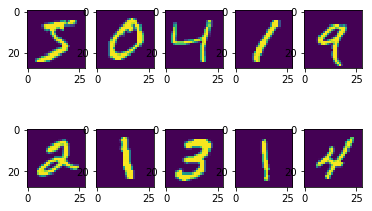

In [2]:
sess = tf.InteractiveSession()
FLAGS=lambda: None
FLAGS.data_dir='data/digits'

training_set = dataset.training_dataset(FLAGS.data_dir)
samples = training_set.batch(10).make_one_shot_iterator().get_next()
samples = sess.run(samples)
f, arr = plt.subplots(2,5)
for row in (0, 1):
    for col in range(5):
        i = 5 * row + col
        img = samples[0][i].reshape([28,28])
        arr[row, col].imshow(img)
samples[1][:10]

So, that's good. Let's take the zeros within the first 10'000 images (There are 1001 of those). Enjoy the beautiful functional interface of the datasets!

1001

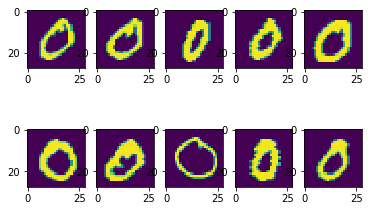

In [3]:
sess = tf.InteractiveSession()
FLAGS=lambda: None 
FLAGS.data_dir='data/digits'

training_set = dataset.training_dataset(FLAGS.data_dir)
samples = training_set.repeat().batch(10000).make_one_shot_iterator().get_next()
_samples = sess.run(samples)

# Functional interfaces: Read from bottom to top: zip - then filter - then map
zeros = list(map( lambda r: r[0],          # take the image, drop the class, it's zero anyway!
    filter(lambda r: r[1] == 0,            # filter zero class
           zip(_samples[0],_samples[1])))) # zip images and classes

f, arr = plt.subplots(2,5)
for row in (0, 1):
    for col in range(5):
        i = 5 * row + col
        img = np.reshape(zeros[i], [28,28])
        arr[row, col].imshow(img)
len(zeros)

Now, we'll extract the center pixel No. 406 and observe the distribution of it's value within the zeros compared to the entire batch of 10'000 images

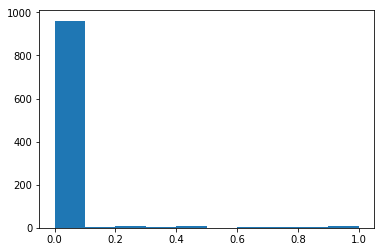

In [4]:
# An image has 28x28=784 pixels, hence 784/2 + 14 = 406 is the center pixel (Ok, ok, it's one of the four center pixels!)
CENTER_POS = 406

centers_0    = list(map(lambda img: img[CENTER_POS], zeros))
centers_all  = list(map(lambda img: img[CENTER_POS], _samples[0]))
_=plt.hist(centers_0, bins=10)

As promised, apart from a few exceptions, almost all pixels are zero or very close to zero. Let's see the distribution of the center pixel values if all different digits.

array([3782.,  261.,  286.,  259.,  260.,  250.,  304.,  341.,  360.,
       3897.])

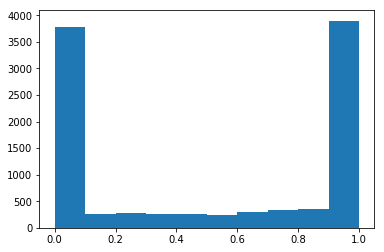

In [5]:
_=plt.hist(centers_all, bins=10)
_[0]

As opposed to the above, the distribution within the entire batch of 10'000 is less predictable, i.e. it has a higher entropy.

To compute the entropy of the distribution, we take the partition counts. Note the special handling of the last bin.

In [6]:
def partition_count(D, N):
    d = (np.max(D) - np.min(D))/N 
    c = np.array(D)
    counts = [np.sum((c >= k/N) * (c < k/N+d)) for k in range(N)]
    counts[N-1] += np.sum(c == np.max(D))
    return np.array(counts)

In [7]:
partition_count(centers_all, 10)

array([3782,  261,  286,  259,  260,  250,  304,  341,  360, 3897])

In [8]:
partition_count(centers_0, 10)

array([961,   6,   7,   3,   7,   1,   4,   2,   2,   8])

Now we compute the entropy of all center pixels compared to entropy of all $zero$'s center pixels

We had: $ H(X) := -\sum_{x \in \mathcal{X}} p(x) \log p(x)$

In [10]:
probs_all = partition_count(centers_all, 10) / 10000

entropy_all = -np.sum(probs_all * np.log(probs_all))

probs_0 = partition_count(centers_0, 10) / 1001

entropy_0 = -np.sum(probs_0 * np.log(probs_0))

print("entropy given x=0: %s" % entropy_0)
print("total entropy:     %s" % entropy_all)

entropy given x=0: 0.24904864416161798
total entropy:     1.5546047214294172


You can now see that the entropy of the entire batch of 10'000 is much higher than the entropy of the distribution given that the digit is known to be 0. Note that the partition count is not a differentiable function of the values in the distribution. To use the concept of entropy in the context of gradient descent, we need a differentiable approximation of the partitioning function. 

Please be aware that the actual value of the entropy critically depends on the number of bins (or partitions):

In [48]:
def probs_all(n_bins):
    return partition_count(centers_all, n_bins) / 10000

[-np.sum(probs_all(n) * np.log(probs_all(n))) for n in range(5, 15)]

[1.2168332446532635,
 1.3097585265532563,
 1.385292573993926,
 1.4492236695331937,
 1.5064213236719182,
 1.5546047214294172,
 1.597813961249977,
 1.6418669196087423,
 1.6879621530351372,
 1.7211309660412366]

### 3. Interlude: Differentiable Partitioning

We have seen how we can calculate the total entropy and the conditional entropy with regards to the labels of a mini-batch of image samples with the help of simple statistics based on binned distributions. In order to use the entropy as a cost function within the concept of gradient-based optimization later on, we need a differentiable approximation of the entropy terms. That turns out to be a surprisingly easy exercise. 

Remember the sigmoid function?
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Let's use two of these to create a more interesting kind of *partitioning* function:

$ f(x) = \sigma(x - x_l) \cdot \sigma(x + x_r) $

For example, for $x_l=5$ and $x_r=15$, that function looks like

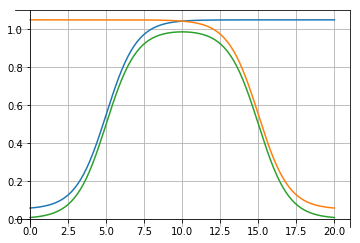

In [13]:
def f(x, x_l, x_r):
    return sigmoid(x - x_l) * sigmoid(-x + x_r)
x=np.linspace(0, 20, 200)
fig, ax = plt.subplots()
ax.plot(x, sigmoid(x-5)+.05)
ax.plot(x, sigmoid(15-x)+0.05)
ax.plot(x, f(x, 5, 15))

ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

See, what it does? It approximately maps all values in a certain bin's range to 1 and all values outside of it to 0. 
Please don't confuse this with a gaussian.

To make this function more square-looking and treat the borders appropriate, we introduce stretch and margin parameters. You'll easily figure out yourself what they do.

Here's the precise definition that we'll use in the following calucations:

Let $ x_i \in [x_{min}, x_{max}] $ be a sample from distribution $D$, $d=x_{max}-x_{min}$,
let $\alpha, \epsilon$ be arbitrary real numbers representing a stretch and a margin, then we define the *bin filter* $\beta_n(x)$ for the $n$-th bin of width $d$ as

$$ \beta_n(x_i) = \sigma(\alpha \cdot (x_i - l_n) + \epsilon) \cdot 
 \sigma(\alpha \cdot ( -x_i + l_n + d + \epsilon))
$$

Here, $l_n$ is the left border of the $n$-th bin: $l_n = x_{min} + (n-1) \cdot d$ 

In [14]:
def beta(n, N, l, r, alpha, epsilon):
    """
    return the bin function for the n-th bin of N bins for numbers between l and r
    alpha and epsilon are stretch and margin parameters
    """
    d = (r - l) / N
    l_n = l + (n-1) * d
    def _beta(x):
        sigmoid_left = tf.nn.sigmoid(alpha * (x-l_n+epsilon)) 
        sigmoid_right = tf.nn.sigmoid(alpha*(-x+l_n+d+epsilon))
        return sigmoid_left * sigmoid_right
    
    return _beta

As an example, we plot the partitioning function that maps values between $ 0.2 $ and $ 0.3 $ to the value $ 1 $ and all others to $ 0 $. Applying this function $\beta_3(x)$ to a sample produces $1$s whereever the single value in the sample is within that range, and $0$s otherwise. The sum of all the values is the number of the examples in that particular partition.

In [15]:
ALPHA=1e4
EPSILON=1e-5

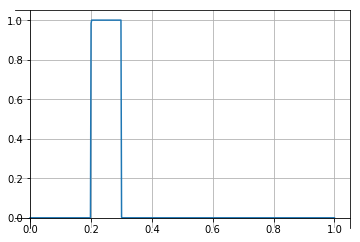

In [21]:
x=np.linspace(0, 1, 500)
fig, ax = plt.subplots()
beta3=beta(3, 10, 0, 1, alpha=ALPHA, epsilon=EPSILON)
beta3_x = sess.run(beta3(x))
ax.plot(x, beta3_x)
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

Now, let us count the number of pixels that fell between $0.2$ and $0.3$

In [29]:
# Please note that betas[0] is not used. We count the bins in a natural manner
betas = [beta(n, 10, 0, 1, alpha=ALPHA, epsilon=EPSILON) for n in range(11)]
betas[0]=None

In [28]:
sess = tf.InteractiveSession()
# The scaling (factor 0.98) and shifting by 0.01 makes sure, we don't count 0s and 1s only as halves
tf_center_all = samples[0][:, CENTER_POS] * .98 + 0.01
tf_center_all_labels = samples[1]
N_k = [tf.reduce_sum(betas[k](tf_center_all)) for k in range(1, 11)] 
differentiable = list(sess.run(tf.cast(N_k, tf.int32)))
print("Differentiable bin count %s" % differentiable)
classical = list(partition_count(centers_all, 10))
print("Classical bin count      %s" % classical)
deviations = list(np.round(np.divide(np.subtract(differentiable,classical),classical)*100,2))
print("Deviation in %%:         %s" % deviations)

Differentiable bin count [3760, 269, 291, 268, 260, 255, 311, 357, 372, 3857]
Classical bin count      [3782, 261, 286, 259, 260, 250, 304, 341, 360, 3897]
Deviation in %:         [-0.58, 3.07, 1.75, 3.47, 0.0, 2.0, 2.3, 4.69, 3.33, -1.03]


Please observe that the resulting numbers are *reasonably* close to the classical counts. Since we're not interested in the actual value but rather their behaviour over time, that can be considered acceptable.

Below, we compute the partition functions in a slightly different way. Note that the functions cover a range of values slightly extended to the left and the right. That's because the distribution has the majority of samples at the borders $0.0$ and $1.0$, and we want to make sure that these border values are counted correctly, too. The partition functions given below have maxima exactly at the borders. This allows us to relax the stretching through parameter alpha. As a net result, gradients will be more well-behaved, at the cost of slightly decreased accuracy.

In [34]:
def part_funs(D, N, alpha):
    """
    Compute the array of partitions functions that count the number of values 
    in each of the N partitions of the discrete distribution D
    """
    d_max=tf.reduce_max(D)
    d_min=tf.reduce_min(D)
    d = (d_max - d_min) / (N-1)
    d_min = d_min - d/2
    d_max = d_max + d/2
    M = tf.cast(tf.size(D), dtype=tf.float32)
    
    return [beta(k, N, d_min, d_max, alpha, epsilon=0) for k in range(1, N+1)]

In [35]:
sess = tf.InteractiveSession()
betas = part_funs(tf_center_all, 10, alpha=1e4)
distr = [tf.reduce_sum(betas[k](tf_center_all)) for k in range(10)]
sess.run(distr)

[3628.977,
 326.02313,
 325.01813,
 294.9538,
 273.02808,
 273.0264,
 336.96368,
 398.0099,
 496.0412,
 3647.9587]

### 4. Computing the Entropy of a discrete distribution  

The Entropy of a distribution X was defined as

$$ H(X) := -\sum_{x \in \mathcal{X}} p(x) \log p(x)$$

Using the bin counts $c_k$ with $\sum c_k = M$ as shown above, we get

$$ H(X) = -\sum_{k=1}^N  \frac{c_k}{M} \log  \frac{c_k}{M}$$

thus, using our differentiable partition counter functions $\beta_k(x_i)$

$$ c_k = \sum_{i=1}^M \beta_k(x_i) $$

the approximation can be computed by

$$ \tilde{H}(X) = \log M -\frac{1}{M}\sum_{k=1}^N  \sum_{i=1}^M \beta_k(x_i)  \log  \sum_{i=1}^M \beta_k(x_i) $$



As we see, the counts are still not too far what the discrete count yielded.

The approximated, differentiable entropy, computed using Tensorflow:

$$ \tilde{H}(X) = \log M -\frac{1}{M}\sum_{k=1}^N  \sum_{i=1}^M \beta_k(x_i)  \log  \sum_{i=1}^M \beta_k(x_i) $$

In [36]:
def entropy(D, N, alpha):
    """
    Calculate the entropy of the discrete sample D using N partitions 
    """
    M = tf.cast(tf.size(D), dtype=tf.float32)
    
    partitions=part_funs(D, N, alpha)
    c=[tf.reduce_sum(partitions[k](D)) for k in range(N)] # this is counting the partitions

    sums = tf.reduce_sum(c * tf.log(c)) # this is the sum over all partitions
    return tf.log(M) - sums / M

In [37]:
sess = tf.InteractiveSession()
sess.run(entropy(tf_center_all, 10, alpha=1e2))

1.6869102

Now, the conditional entropy goes just the same way, only that we need to mask the classes out after counting the samples in each bin. Masking is obviously done with the help of the labels that usually come with the training samples.

Remember how we calculate the conditional entropy? In our case, $x$ is the class label - the prior - and $y$ is the index of the bin or partition that the pixel is sorted into.

$$ H(Y \big| X) = - \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log(\frac{p(x,y)}{p(x)})$$

The implementation is pretty straight-forward

In [40]:
def cond_entropy(D, L, N_classes, N_bins, alpha):
    """
        calculate the conditional entropy of distribution D given labels L
    """
    
    betas = part_funs(D, N_bins, alpha)
    
    M=tf.cast(tf.size(D), dtype=tf.float32)

    # The mask is used to count by class
    mask = [ tf.cast(tf.equal(c, L), tf.float32) for c in range(N_classes) ]
    # N_classes lists of counts => N_classes conditional distributions
    cond_counts = [
        [
            tf.reduce_sum(betas[n](D) * mask[k]) for n in range(N_bins)
        ] for k in range(N_classes)
    ]

    pxy = cond_counts / M                       # p(x,y)
    px = tf.reduce_sum(cond_counts, axis=1) / M # p(x)

    epsilon_stab = 1e-4 # to stabilize the log term
    # need to transpose forth and back to enable broadcasting
    pxy_px = tf.transpose(tf.transpose(pxy) / (tf.transpose(px)) + epsilon_stab) 

    return -tf.reduce_sum(pxy * tf.log(pxy_px))

In [41]:
sess = tf.InteractiveSession()
D = tf_center_all
L = tf_center_all_labels
sess.run(cond_entropy(D, L, N_classes=10, N_bins=10, alpha=ALPHA))

1.3828831

Now we look at the information gain:
$ I(X;Y) = H(Y) - H(Y|X) $

In [42]:
def info_gain(D, L, N_classes, N_bins, alpha):
    H_D = entropy(D, N_classes, alpha)
    H_cond = cond_entropy(D, L, N_classes, N_bins, alpha)
    return H_D - H_cond

In [44]:
sess = tf.InteractiveSession()
sess.run(info_gain(D, L, N_classes=10, N_bins=10, alpha=1e2))

0.28876078

Let's see what happens when we vary the number of partitions

In [45]:
sess = tf.InteractiveSession()
gains_bins=[info_gain(D, L, N_classes=10, N_bins=n, alpha=1e2) for n in range(5, 15)]
sess.run(gains_bins)

[0.6390507,
 0.54783213,
 0.47079957,
 0.40283108,
 0.34296823,
 0.28876078,
 0.23875403,
 0.19057584,
 0.14553034,
 0.10231459]

Note that the actual value for the information gain depends on the number of partitions that we use, which is arguably not a desired outcome. But that behaviour stems from the discrete partitioning itself. Results coming from different partitionings are not comparable. Still the behaviour of the entropy and the information gain, given a fixed partitioning, can yield valuable insights into the inner workings of neural networks.